In [9]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader


CATSnDOGS = np.array(pd.read_csv("CATSnDOGS.csv"))
Labels = np.array(pd.read_csv("Labels.csv"))

CATSnDOGS = CATSnDOGS.reshape(-1, 1, 64, 64)
data = torch.from_numpy(CATSnDOGS).float()
labels = torch.from_numpy(Labels.ravel()).long()

dataset = TensorDataset(data, labels)

In [10]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*8*8, out_features=256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.pool3(x)
        x = x.view(-1, 128*8*8)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [11]:
def train(model, train_loader, val_loader, num_epochs, lr, patience):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize variables for early stopping
    best_val_acc = 0.0
    num_epochs_no_improve = 0

    # Train the model
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()

        # Iterate over batches in the training data
        for inputs, labels in train_loader:
            # Zero out the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        # Print training and validation metrics
        train_loss = loss.item()
        train_correct = torch.sum(preds == labels.data)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        #print("Epoch {}/{} - Training Loss: {:.4f} - Training Accuracy: {:.4f} - Validation Loss: {:.4f} - Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

        # Check if validation accuracy has improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            num_epochs_no_improve = 0
        else:
            num_epochs_no_improve += 1

        # Check if we have exceeded patience for early stopping
        if num_epochs_no_improve >= patience:
            #print('Validation accuracy did not improve for {} epochs. Stopping early.'.format(patience))
            break

    # Return the trained model
    return model



In [12]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from tqdm import tqdm

mean_recall_list = []
mean_precision_list = []
mean_accuracy_list = []

recall_list = []
precision_list = []
accuracy_list = []

misclassified_counter = Counter()

num_folds = 5
iterations = 100
criterion = nn.CrossEntropyLoss()

# Set up outer loop for cross-validation
for i in range(iterations):
    # Set up progress bar for each iteration
    with tqdm(total=num_folds, desc=f"Iteration {i+1}/{iterations}", leave=False, position=0, dynamic_ncols=True) as pbar:
        kf = KFold(n_splits=num_folds, shuffle=True)

        # Set up inner loop for each fold in cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            # Update the progress bar for each completed fold
            pbar.update(1)

            # Set up data loaders
            train_data = Subset(dataset, train_idx)
            val_data = Subset(dataset, val_idx)
            train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

            # Train model on the training set
            model = CNN()
            cnn = train(model, train_loader, val_loader, num_epochs=50, lr=0.001, patience=5)

            # Evaluate model on the validation set
            model.eval()
            val_correct = 0
            val_preds = []
            val_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    val_correct += torch.sum(preds == labels.data)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.data.cpu().numpy())
                    
                    for i in range(len(labels)):
                        if preds[i] != labels[i]:
                            # Increment counter only if predicted label is not equal to true label
                            idx = val_data.indices[i]  # Get index of misclassified image in the original dataset
                            misclassified_counter[idx] += 1  # Update counter for misclassified images
                    
            
            val_acc = val_correct / len(val_loader.dataset)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)

            # Store evaluation metrics for this fold
            recall_list.append(val_recall)
            precision_list.append(val_precision)
            accuracy_list.append(val_acc)
       
        # Compute the mean evaluation metrics over all folds for this iteration and store them for this iteration
        mean_recall_list.append(np.mean(recall_list))
        mean_precision_list.append(np.mean(precision_list))
        mean_accuracy_list.append(np.mean(accuracy_list))
        
        # Clear the lists for the next iteration
        recall_list = []
        precision_list = []
        accuracy_list = []
        
# Compute the mean evaluation metrics over all iterations
recall = np.mean(mean_recall_list)
precision = np.mean(mean_precision_list)
accuracy = np.mean(mean_accuracy_list)


Accuracy: 0.8565
Precision: 0.8631
Recall: 0.8583


In [13]:
# Print the mean evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


print(misclassified_counter)

Accuracy: 0.8565
Precision: 0.8631
Recall: 0.8583
Counter({8: 120, 26: 113, 12: 111, 37: 108, 63: 101, 114: 100, 131: 100, 54: 99, 117: 97, 112: 81, 151: 80, 93: 77, 71: 74, 98: 69, 21: 57, 89: 55, 33: 54, 158: 44, 107: 37, 85: 36, 3: 35, 14: 35, 139: 35, 10: 35, 18: 33, 27: 32, 165: 29, 2: 28, 162: 28, 9: 25, 7: 24, 5: 23, 17: 22, 49: 22, 25: 21, 53: 21, 161: 21, 11: 21, 1: 20, 113: 20, 6: 20, 135: 20, 16: 19, 4: 19, 47: 19, 19: 18, 20: 18, 108: 18, 13: 18, 24: 18, 22: 17, 133: 17, 15: 16, 170: 16, 0: 16, 90: 16, 36: 15, 43: 14, 29: 14, 80: 14, 136: 14, 143: 14, 34: 13, 28: 13, 103: 12, 102: 12, 58: 12, 40: 12, 127: 12, 31: 12, 126: 12, 30: 10, 123: 10, 86: 9, 44: 9, 39: 9, 32: 9, 79: 8, 88: 8, 124: 7, 23: 7, 116: 7, 38: 7, 69: 7, 35: 7, 41: 7, 73: 7, 171: 6, 51: 6, 176: 5, 148: 5, 129: 4, 120: 4, 96: 4, 105: 4, 100: 4, 50: 4, 95: 3, 122: 3, 137: 3, 177: 3, 48: 3, 61: 2, 75: 2, 87: 2, 78: 2, 42: 2, 106: 2, 55: 2, 68: 2, 104: 1, 155: 1, 121: 1, 81: 1, 92: 1, 57: 1, 83: 1, 64: 1, 52: 1,

In [17]:
from collections import Counter

counter = {8: 120, 26: 113, 12: 111, 37: 108, 63: 101, 114: 100, 131: 100, 54: 99, 117: 97, 112: 81, 151: 80, 93: 77, 71: 74, 98: 69, 21: 57, 89: 55, 33: 54, 158: 44, 107: 37, 85: 36, 3: 35, 14: 35, 139: 35, 10: 35, 18: 33, 27: 32, 165: 29, 2: 28, 162: 28, 9: 25, 7: 24, 5: 23, 17: 22, 49: 22, 25: 21, 53: 21, 161: 21, 11: 21, 1: 20, 113: 20, 6: 20, 135: 20, 16: 19, 4: 19, 47: 19, 19: 18, 20: 18, 108: 18, 13: 18, 24: 18, 22: 17, 133: 17, 15: 16, 170: 16, 0: 16, 90: 16, 36: 15, 43: 14, 29: 14, 80: 14, 136: 14, 143: 14, 34: 13, 28: 13, 103: 12, 102: 12, 58: 12, 40: 12, 127: 12, 31: 12, 126: 12, 30: 10, 123: 10, 86: 9, 44: 9, 39: 9, 32: 9, 79: 8, 88: 8, 124: 7, 23: 7, 116: 7, 38: 7, 69: 7, 35: 7, 41: 7, 73: 7, 171: 6, 51: 6, 176: 5, 148: 5, 129: 4, 120: 4, 96: 4, 105: 4, 100: 4, 50: 4, 95: 3, 122: 3, 137: 3, 177: 3, 48: 3, 61: 2, 75: 2, 87: 2, 78: 2, 42: 2, 106: 2, 55: 2, 68: 2, 104: 1, 155: 1, 121: 1, 81: 1, 92: 1, 57: 1, 83: 1, 64: 1, 52: 1, 74: 1, 45: 1, 169: 1, 46: 1, 164: 1}


In [18]:
def get_misclassified_indices(clf, features, labels, dataset):
    # Make predictions on the input data
    y_pred = clf.predict(features)
    
    # Find misclassified samples
    misclassified_idx = [i for i in range(len(labels)) if labels[i] != y_pred[i]]
    misclassified = features[misclassified_idx]
    
    # Find indices of misclassified samples in the original dataset
    indices = []
    for i in range(misclassified.shape[0]):
        image = misclassified[i,:]
        idx = np.where((dataset==image).all(axis=1))[0][0]
        indices.append(idx)
    
    return indices

In [19]:
def common(counts, threshold):
    most_common = []
    for key, count in counts.items():
        if count > threshold:
            most_common.append(key)
    most_common = sorted(most_common, key=lambda key: counts[key], reverse=True)
    return most_common

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mislabel_counts(counts_dic, title):
    
    # Create bar plot
    counts = list(counts_dic.values())
    features = list(counts_dic.keys())
    plt.bar(features, counts)
    plt.xlabel('Images')
    plt.ylabel('Misclassified count')
    plt.title(title)
    plt.show()

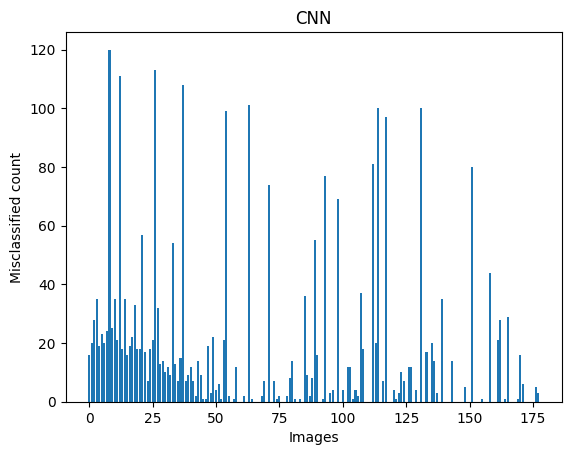

In [23]:
plot_mislabel_counts(counter, 'CNN')

In [25]:
threshold = iterations * 0.2
most_common = common(counter, threshold)

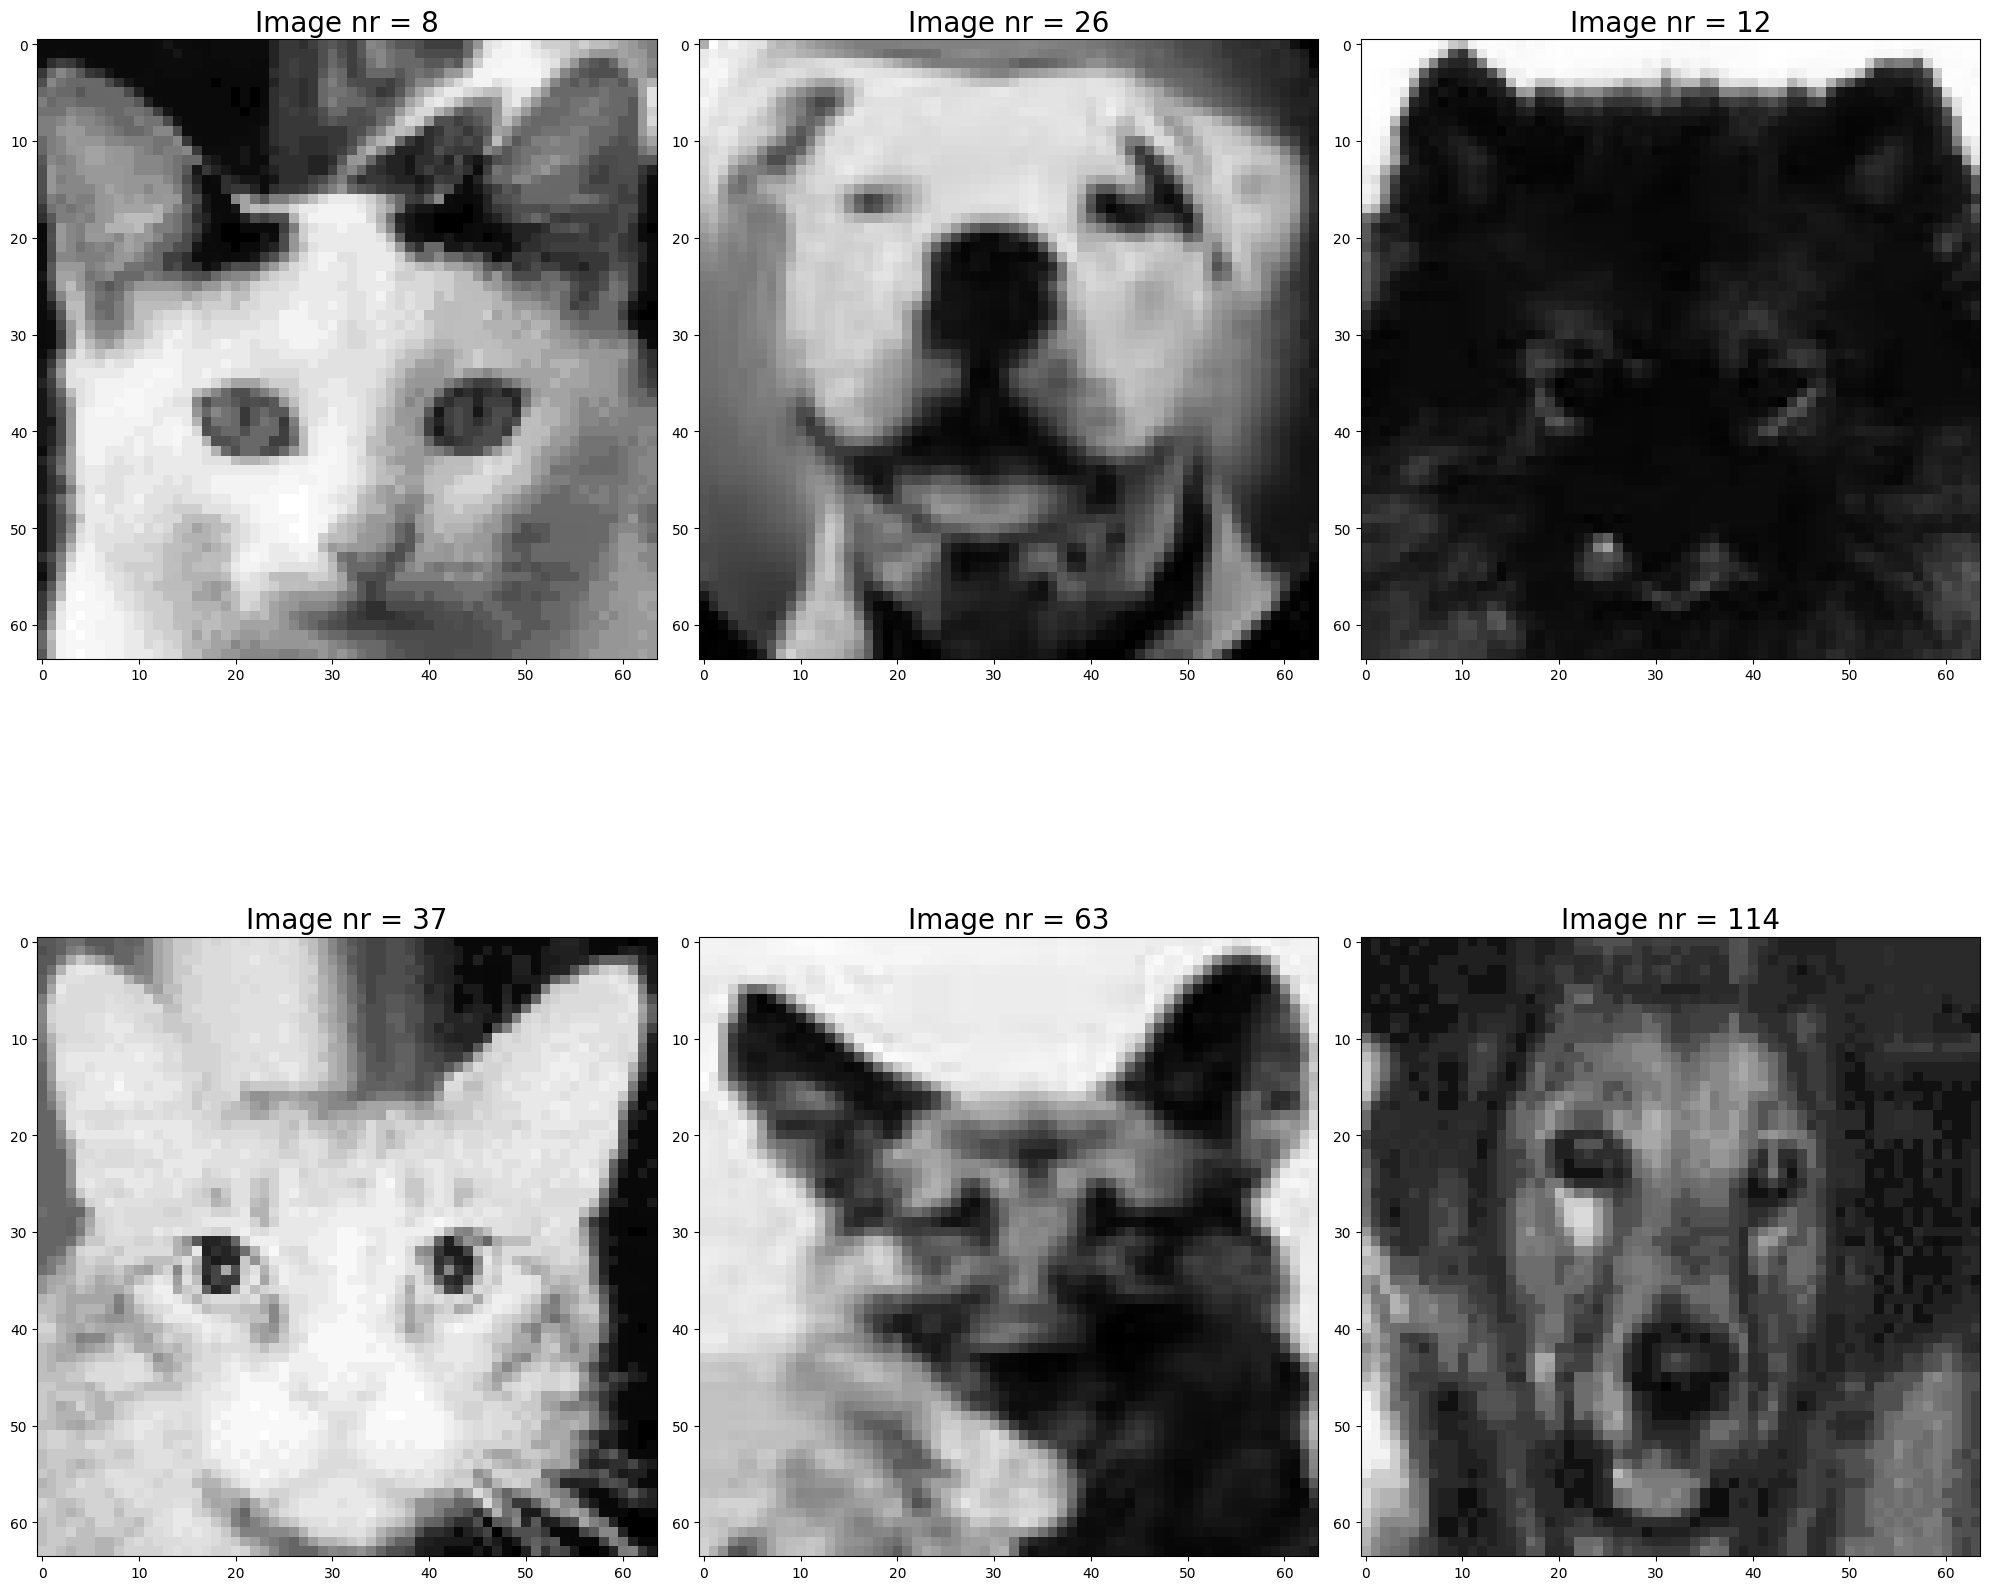

In [27]:
# Show the 6 most misclassified images

def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(CATSnDOGS[most_common[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        axes[i][j].set_title(f'Image nr = {most_common[id]}', fontsize=20)
        id += 1
plt.tight_layout()